In [1]:
import numpy   as np
import pandas  as pd
import seaborn as sns

import df_visualizations as dv
import remap_values as rv

import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn               import linear_model

In [2]:
%matplotlib inline
plt.style.use( 'dark_background' )
plt.rcParams['figure.figsize'] = (14,10)

In [3]:
use_list = ['parcelid',
    'logerror','transactiondate','airconditioningtypeid','pooltypeid10', # Hotub
    'poolsizesum','garagetotalsqft','calculatedbathnbr','fireplacecnt',
    'finishedsquarefeet12','lotsizesquarefeet','taxdelinquencyflag','yearbuilt',
    'structuretaxvaluedollarcnt','taxvaluedollarcnt','landtaxvaluedollarcnt','taxamount',
    'decktypeid','numberofstories','buildingqualitytypeid','unitcnt','roomcnt' ]

In [4]:
prop  = pd.read_csv( 'data/properties_2016.csv' )
trans = pd.read_csv( 'data/train_2016_v2.csv'   )

my_df = pd.merge( prop, trans, on='parcelid', how='inner' )
my_df = my_df[ use_list ]

del prop
del trans

my_df['transactiondate' ] =   pd.to_datetime  ( my_df['transactiondate'] )
my_df['time_since_built'] = ( pd.DatetimeIndex( my_df['transactiondate'] ).year - my_df['yearbuilt'] )
my_df['ordinal_date'    ] =  [x.toordinal() for x in my_df['transactiondate']]
my_df['day_of_week'     ] = ( my_df['ordinal_date'] - my_df['ordinal_date'].min() + 2 ) % 7

my_df = my_df.drop( ['yearbuilt'], axis=1 )

print my_df.shape

/home/sean/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (22,32,34,49,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(90275, 24)


In [15]:
my_df.columns.values

array(['parcelid', 'logerror', 'transactiondate', 'airconditioningtypeid',
       'pooltypeid10', 'poolsizesum', 'garagetotalsqft',
       'calculatedbathnbr', 'fireplacecnt', 'finishedsquarefeet12',
       'lotsizesquarefeet', 'taxdelinquencyflag',
       'structuretaxvaluedollarcnt', 'taxvaluedollarcnt',
       'landtaxvaluedollarcnt', 'taxamount', 'decktypeid',
       'numberofstories', 'buildingqualitytypeid', 'unitcnt', 'roomcnt',
       'time_since_built', 'ordinal_date', 'day_of_week'], dtype=object)

In [5]:
# Only flag which units have AC

my_df['has_ac'] = 1

my_df.ix[ my_df['airconditioningtypeid'].isnull(), ['has_ac'] ] = 0
my_df.ix[ my_df['airconditioningtypeid'] == 5    , ['has_ac'] ] = 0

my_df = my_df.drop( 'airconditioningtypeid', axis=1 )




# Flag for has pool, has spa, size of pool

my_df['has_spa'  ] = 0
my_df['has_pool' ] = 0
my_df['pool_sqft'] = 0

my_df['has_spa'  ] = my_df['pooltypeid10'].fillna(0).astype(int)
my_df['pool_sqft'] = my_df['poolsizesum' ]
my_df['has_pool' ] =(my_df['poolsizesum' ] > 0).astype(int)

my_df = my_df.drop( ['pooltypeid10','poolsizesum'], axis=1 )




# Save the sqft in better variables

my_df['unit_sqft'] = my_df['finishedsquarefeet12']
my_df[ 'lot_sqft'] = my_df['lotsizesquarefeet'   ]

my_df = my_df.drop( ['finishedsquarefeet12', 'lotsizesquarefeet'], axis=1 )






# n_units, if nan most likely a single unit. 1/nan, 2, 3, 4, multi

my_df['unitcnt'].unique()

my_df['n_units_single'] = 0
my_df['n_units_double'] = 0
my_df['n_units_multi' ] = 0

my_df.ix[ my_df['unitcnt'].isnull() , 'n_units_single' ] = 1
my_df.ix[ my_df['unitcnt'] == 1     , 'n_units_single' ] = 1
my_df.ix[ my_df['unitcnt'] == 2     , 'n_units_double' ] = 1
my_df.ix[ my_df['unitcnt'] >  2     , 'n_units_multi'  ] = 1

my_df = my_df.drop( 'unitcnt', axis=1 )





# Flag for tax delinquency

my_df['tax_delinquent'] = my_df['taxdelinquencyflag'].fillna(0).replace( {'Y': 1} )

my_df = my_df.drop( 'taxdelinquencyflag', axis=1 )





# Break building quality into categories

my_df['building_quality_low' ] = 0
my_df['building_quality_med' ] = 0
my_df['building_quality_high'] = 0
my_df['building_quality_unkn'] = 0

my_df.ix[  my_df['buildingqualitytypeid'] < 4     , 'building_quality_high' ] = 1
my_df.ix[  my_df['buildingqualitytypeid'] > 8     , 'building_quality_low'  ] = 1
my_df.ix[ (my_df['buildingqualitytypeid'] > 3)    &
        (  my_df['buildingqualitytypeid'] < 9)    , 'building_quality_med'  ] = 1
my_df.ix[  my_df['buildingqualitytypeid'].isnull(), 'building_quality_unkn' ] = 1

my_df = my_df.drop( 'buildingqualitytypeid', axis=1 )





# Have flag for garage, and sqft variable

my_df['has_garage' ] = 0
my_df['garage_sqft'] = my_df['garagetotalsqft'].fillna(0)

my_df.ix[ my_df['garagetotalsqft']>1, 'has_garage' ] = 1

my_df = my_df.drop( 'garagetotalsqft', axis=1 )






# Break into single, multi-story flag

my_df['n_stories_single'] = 0
my_df['n_stories_multi' ] = 0
my_df['n_stories_unkn'  ] = 0

my_df.ix[ my_df['numberofstories'] == 1    , 'n_stories_single' ] = 1
my_df.ix[ my_df['numberofstories'] >  1    , 'n_stories_multi'  ] = 1
my_df.ix[ my_df['numberofstories'].isnull(), 'n_stories_unkn'   ] = 1


my_df = my_df.drop( 'numberofstories', axis=1 )






# 1 hot encode deck, var for number of fireplaces

my_df['n_fireplaces'] = my_df['fireplacecnt'].fillna(0)
my_df['has_deck'    ] = my_df['decktypeid'  ].notnull().astype(int)

my_df = my_df.drop( ['fireplacecnt','decktypeid'], axis=1 )



# Drop any duplicate rows

my_df = my_df.drop_duplicates( subset='parcelid', keep="last")

In [7]:
my_df.columns.values

array(['logerror', 'transactiondate', 'calculatedbathnbr',
       'structuretaxvaluedollarcnt', 'taxvaluedollarcnt',
       'landtaxvaluedollarcnt', 'taxamount', 'roomcnt', 'time_since_built',
       'ordinal_date', 'day_of_week', 'has_ac', 'has_spa', 'has_pool',
       'pool_sqft', 'unit_sqft', 'lot_sqft', 'n_units_single',
       'n_units_double', 'n_units_multi', 'tax_delinquent',
       'building_quality_low', 'building_quality_med',
       'building_quality_high', 'building_quality_unkn', 'has_garage',
       'garage_sqft', 'n_stories_single', 'n_stories_multi',
       'n_stories_unkn', 'n_fireplaces', 'has_deck'], dtype=object)

In [49]:
remain_list = ['calculatedbathnbr', 'structuretaxvaluedollarcnt', 'taxvaluedollarcnt', 'landtaxvaluedollarcnt', 
               'taxamount', 'roomcnt']

In [21]:
most_stuff = ['logerror', 'calculatedbathnbr',
       'structuretaxvaluedollarcnt', 'taxvaluedollarcnt',
       'landtaxvaluedollarcnt', 'taxamount', 'numberofstories', 'unitcnt',
       'roomcnt', 'time_since_built', 'ordinal_date', 'day_of_week',
       'has_ac', 'has_spa', 'has_pool', 'pool_sqft', 'unit_sqft',
       'lot_sqft', 'tax_delinquent', 'building_quality_low',
       'building_quality_med', 'building_quality_high',
       'building_quality_unkn', 'has_garage', 'garage_sqft',
       'n_fireplaces', 'has_deck']

In [89]:
my_df[remain_list].isnull().sum().sort_values()

roomcnt                           0
taxvaluedollarcnt                 1
landtaxvaluedollarcnt             1
taxamount                         6
structuretaxvaluedollarcnt      380
calculatedbathnbr              1182
numberofstories               69705
dtype: int64

In [65]:
print my_df.ix[ my_df['taxvaluedollarcnt'].isnull(), ['taxvaluedollarcnt','landtaxvaluedollarcnt','taxamount','structuretaxvaluedollarcnt'] ].head()
print my_df.ix[ my_df['taxamount'].isnull(), ['taxvaluedollarcnt','landtaxvaluedollarcnt','taxamount','structuretaxvaluedollarcnt'] ].head()

       taxvaluedollarcnt  landtaxvaluedollarcnt  taxamount  \
22541                NaN                    NaN       51.4   

       structuretaxvaluedollarcnt  
22541                         NaN  
       taxvaluedollarcnt  landtaxvaluedollarcnt  taxamount  \
1305             42432.0                42432.0        NaN   
34947            68200.0                68200.0        NaN   
51225           179068.0                58912.0        NaN   
62405           224400.0               224400.0        NaN   
64316           104936.0                41227.0        NaN   

       structuretaxvaluedollarcnt  
1305                          NaN  
34947                         NaN  
51225                    120156.0  
62405                         NaN  
64316                     63709.0  


In [23]:
for item in remain_list:
    print item
    print my_df[most_stuff].corrwith( my_df[item] ).sort_values()
    print ' '

calculatedbathnbr
time_since_built             -0.369543
building_quality_med         -0.172283
tax_delinquent               -0.033956
ordinal_date                 -0.005578
lot_sqft                      0.004853
day_of_week                   0.017949
logerror                      0.029448
roomcnt                       0.031486
has_deck                      0.043949
building_quality_unkn         0.045206
has_spa                       0.057994
has_pool                      0.073455
n_fireplaces                  0.100314
has_garage                    0.118644
unitcnt                       0.154641
building_quality_high         0.171318
garage_sqft                   0.193996
has_ac                        0.225834
pool_sqft                     0.254296
building_quality_low          0.257078
numberofstories               0.369760
landtaxvaluedollarcnt         0.371634
taxamount                     0.487320
taxvaluedollarcnt             0.497763
structuretaxvaluedollarcnt    0.611665
unit_sq

Clearly taxvaluedollarcnt and landtaxvaluedollarcnt can be predicted by taxamount,

as well as the converse

[[ 1.22464989]]
[ 0.74546935]


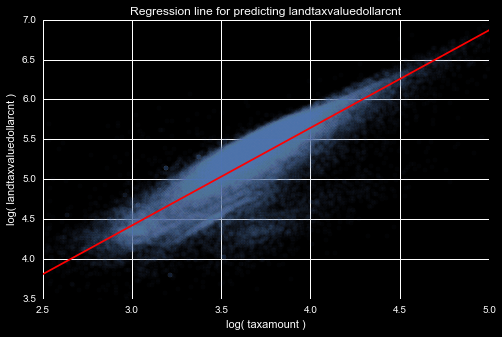

[[ 1.02096126]]
[ 1.78299386]


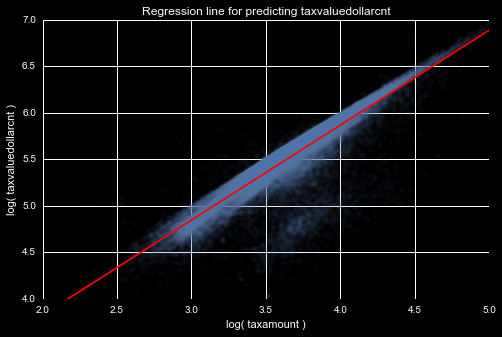

[[ 0.76942817]]
[ 0.87698563]


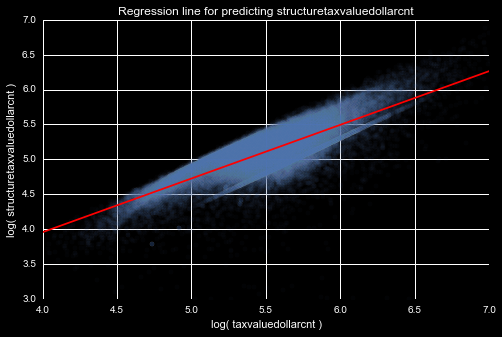

In [109]:
def regression_taxamount( inp_df ):

    # get values, and log them
    foo = np.log10( inp_df[['taxvaluedollarcnt','landtaxvaluedollarcnt','taxamount','structuretaxvaluedollarcnt']] ).copy()
    foo['parcelid'] = inp_df['parcelid']
    
    # Bar is just not null values, for regression
    bar = foo.dropna()
    
        
    # Perform regressions
    land_reg = linear_model.LinearRegression()
    tax_reg  = linear_model.LinearRegression()
    amt_reg  = linear_model.LinearRegression()
    str_reg  = linear_model.LinearRegression()

    
    land_reg.fit( bar['taxamount'        ].to_frame(), bar['landtaxvaluedollarcnt'].to_frame() )
    tax_reg.fit ( bar['taxamount'        ].to_frame(), bar[    'taxvaluedollarcnt'].to_frame() )
    amt_reg.fit ( bar['taxvaluedollarcnt'].to_frame(), bar[            'taxamount'].to_frame() )
    str_reg.fit ( bar['taxvaluedollarcnt'].to_frame(), bar['structuretaxvaluedollarcnt'].to_frame() )
    
#    
    print land_reg.coef_
    print land_reg.intercept_
#    
    xx = np.array( [1,9] )
    foo.plot.scatter( y='landtaxvaluedollarcnt'    , x='taxamount', alpha=0.03, figsize=(8,5) )
    plt.plot( xx, land_reg.coef_[0]*xx + land_reg.intercept_, color='r' )
    plt.xlim(2.5,5)
    plt.ylim(3.5,7)
    plt.xlabel( 'log( taxamount )')
    plt.ylabel( 'log( landtaxvaluedollarcnt )')
    plt.title('Regression line for predicting landtaxvaluedollarcnt')
    plt.show()
#
    print tax_reg.coef_
    print tax_reg.intercept_
#    
    xx = np.array( [1,9] )
    foo.plot.scatter( y='taxvaluedollarcnt'    , x='taxamount', alpha=0.03, figsize=(8,5) )    
    plt.plot( xx, tax_reg.coef_[0]*xx + tax_reg.intercept_, color='r' )
    plt.xlim(2,5)
    plt.ylim(4,7)
    plt.xlabel( 'log( taxamount )')
    plt.ylabel( 'log( taxvaluedollarcnt )')
    plt.title('Regression line for predicting taxvaluedollarcnt')
    plt.show()
#
    print str_reg.coef_
    print str_reg.intercept_
#    
    xx = np.array( [1,9] )
    foo.plot.scatter( x='taxvaluedollarcnt'    , y='structuretaxvaluedollarcnt', alpha=0.03, figsize=(8,5) )    
    plt.plot( xx, str_reg.coef_[0]*xx + str_reg.intercept_, color='r' )
    plt.xlim(4,7)
    plt.ylim(3,7)
    plt.ylabel( 'log( structuretaxvaluedollarcnt )')
    plt.xlabel( 'log( taxvaluedollarcnt )')
    plt.title('Regression line for predicting structuretaxvaluedollarcnt')
    plt.show()


    # Get the id numbers for the rows with NaN values
    for id_num in foo[ foo.drop( 'structuretaxvaluedollarcnt',axis=1).isnull().any(axis=1) ]['parcelid'].values:
        
        # Find which row it is
        row_num = foo.loc[ foo['parcelid'] == id_num ].index
#
#        print foo.loc[ row_num ]
        
        # Depending on what's missing, fill it in
        
        
        if( foo.ix[ row_num, 'landtaxvaluedollarcnt' ].isnull().values ):
            foo.ix[ row_num, 'landtaxvaluedollarcnt' ] = land_reg.predict( foo.ix[ row_num, 'taxamount'         ].values.reshape(-1,1) )
            
        if( foo.ix[ row_num,     'taxvaluedollarcnt' ].isnull().values ):
            foo.ix[ row_num,     'taxvaluedollarcnt' ] =  tax_reg.predict( foo.ix[ row_num, 'taxamount'         ].values.reshape(-1,1) )
            
        if( foo.ix[ row_num,             'taxamount' ].isnull().values ):
            foo.ix[ row_num,             'taxamount' ] =  amt_reg.predict( foo.ix[ row_num, 'taxvaluedollarcnt' ].values.reshape(-1,1) )

    for id_num in foo[ foo.isnull().any(axis=1) ]['parcelid'].values:

        row_num = foo.loc[ foo['parcelid'] == id_num ].index
        
        if( foo.ix[ row_num,'structuretaxvaluedollarcnt'].isnull().values ):
            foo.ix[ row_num,'structuretaxvaluedollarcnt'] =  tax_reg.predict( foo.ix[ row_num,'taxvaluedollarcnt'].values.reshape(-1,1) )

            
    return foo[['taxamount','taxvaluedollarcnt','landtaxvaluedollarcnt','structuretaxvaluedollarcnt']]
            
foo = regression_taxamount( my_df )

my_df['log_tax_amount'] = foo['taxamount']
my_df['log_tax_value' ] = foo['taxvaluedollarcnt']
my_df['log_land_tax'  ] = foo['landtaxvaluedollarcnt']
my_df['log_str_tax'   ] = foo['structuretaxvaluedollarcnt']

del foo

In [50]:
my_df[remain_list].isnull().sum().sort_values()

roomcnt                          0
taxvaluedollarcnt                1
landtaxvaluedollarcnt            1
taxamount                        6
structuretaxvaluedollarcnt     380
calculatedbathnbr             1182
dtype: int64

In [23]:
for item in remain_list:
    print item
    print my_df[most_stuff].corrwith( my_df[item] ).sort_values()
    print ' '

calculatedbathnbr
time_since_built             -0.369543
building_quality_med         -0.172283
tax_delinquent               -0.033956
ordinal_date                 -0.005578
lot_sqft                      0.004853
day_of_week                   0.017949
logerror                      0.029448
roomcnt                       0.031486
has_deck                      0.043949
building_quality_unkn         0.045206
has_spa                       0.057994
has_pool                      0.073455
n_fireplaces                  0.100314
has_garage                    0.118644
unitcnt                       0.154641
building_quality_high         0.171318
garage_sqft                   0.193996
has_ac                        0.225834
pool_sqft                     0.254296
building_quality_low          0.257078
numberofstories               0.369760
landtaxvaluedollarcnt         0.371634
taxamount                     0.487320
taxvaluedollarcnt             0.497763
structuretaxvaluedollarcnt    0.611665
unit_sq

(0, 8)

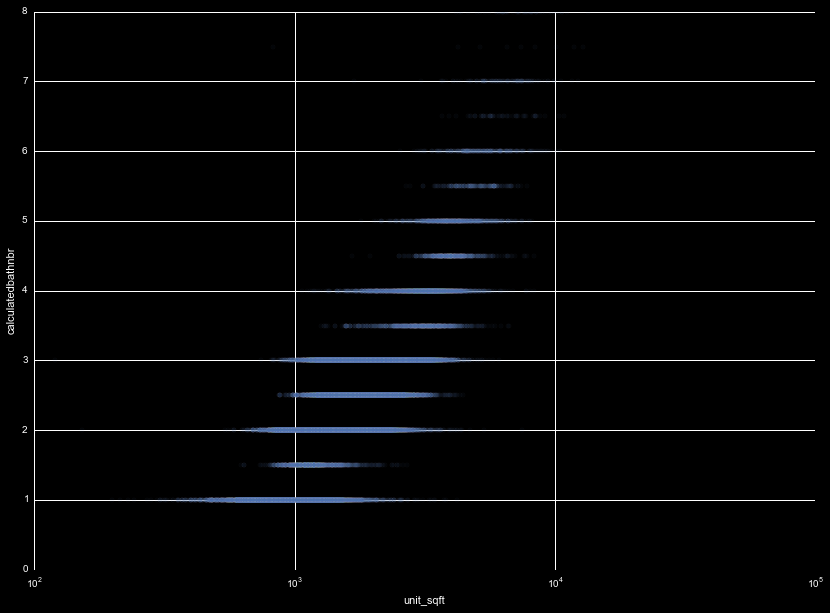

In [33]:
my_df.plot.scatter( x='unit_sqft', y='calculatedbathnbr', alpha=0.05 )
plt.xscale( 'log' )
plt.xlim( [1e2,1e5] )
plt.ylim( [  0,  8] )

(0, 10)

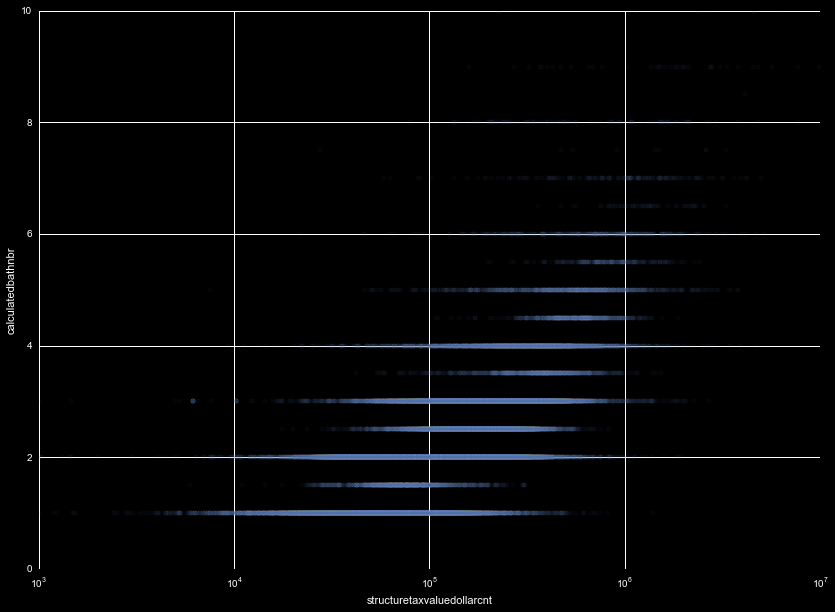

In [80]:
my_df.plot.scatter( x='structuretaxvaluedollarcnt', y='calculatedbathnbr', alpha=0.05 )
plt.xscale( 'log' )
plt.xlim( [1e3,1e7] )
plt.ylim( [  0,10 ] )

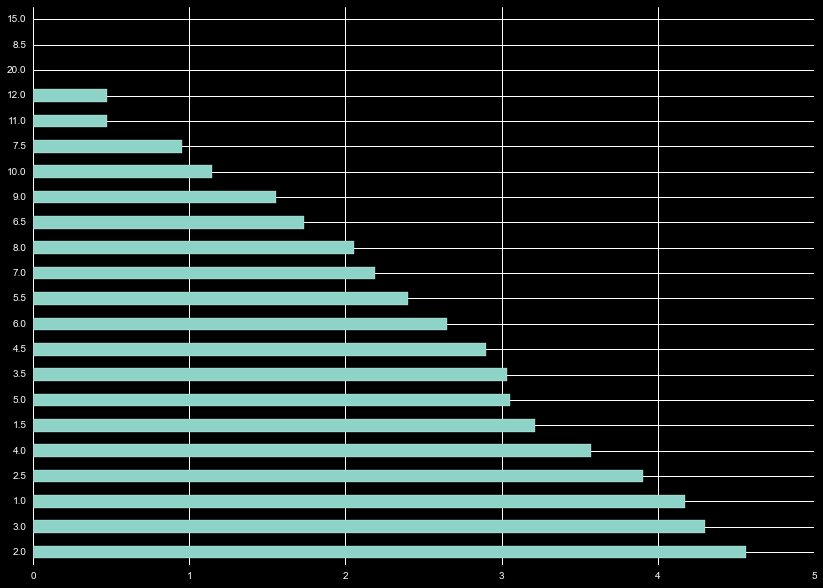

In [142]:
np.log10( my_df['calculatedbathnbr'].value_counts(sort=True) ).plot.barh()

Possible to calculate bathnbr off these parameters, but lots of noise. maybe incorporate type of residence

Vast majority in 1-3, go ahead and fit between 1 and 3 by doubling the number of bathrooms, fitting, predict rounded number

We will treat this as continuous, and a little error is ok

[[ 3.47500608]]
[-13.15680689]


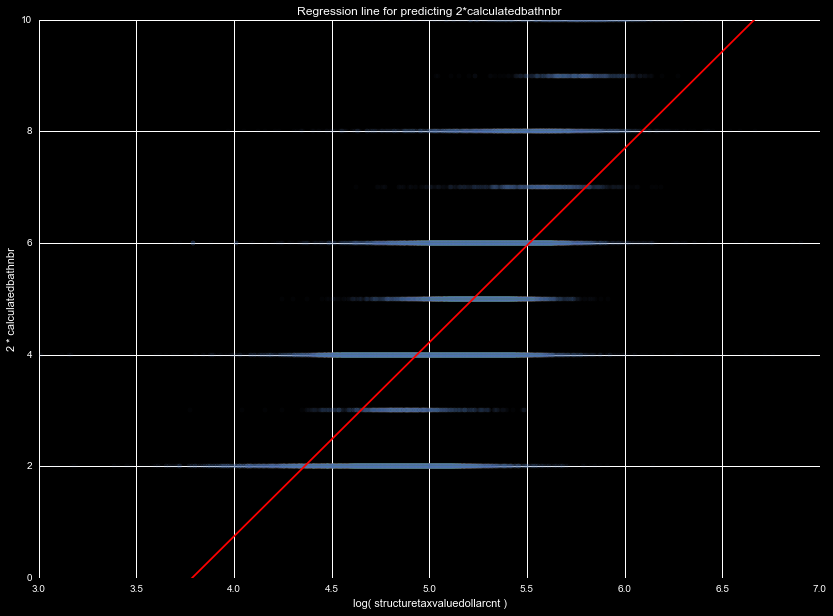

0    2.5
1    1.0
2    2.0
3    1.5
4    2.5
Name: calculatedbathnbr, dtype: float64

In [140]:
def reg_num_bath( inp_df ):
    
    foo = inp_df[['calculatedbathnbr','structuretaxvaluedollarcnt','parcelid']].copy()
    foo['structuretaxvaluedollarcnt'] = np.log10( foo['structuretaxvaluedollarcnt'] ) 
    foo['calculatedbathnbr'         ] = 2 *       foo['calculatedbathnbr'         ]
    
    bar = foo.dropna()
        
    # Perform regressions
    bath_reg = linear_model.LinearRegression()
    
    bath_reg.fit( bar['structuretaxvaluedollarcnt'].to_frame(), bar['calculatedbathnbr'].to_frame() )

#
    print bath_reg.coef_
    print bath_reg.intercept_
#    
    xx = np.array( [1,9] )
    foo.plot.scatter( x='structuretaxvaluedollarcnt', y='calculatedbathnbr', alpha=0.03, figsize=(14,10) )    
    plt.plot( xx, bath_reg.coef_[0]*xx + bath_reg.intercept_, color='r' )
    plt.xlim(3,7)
    plt.ylim(0,10)
    plt.ylabel( '2 * calculatedbathnbr')
    plt.xlabel( 'log( structuretaxvaluedollarcnt )')
    plt.title('Regression line for predicting 2*calculatedbathnbr')
    plt.show()
    
    a=10
    
    # Don't need to worry about going through rows
    # Locate bad indexes, and fill those spots with predicted values
    null_index = foo.isnull().any(axis=1)

    # Do regression
    foo.ix[ null_index, ['calculatedbathnbr'] ] = \
        bath_reg.predict( foo.ix[ null_index, 'structuretaxvaluedollarcnt' ].values.reshape(-1,1) )
        
    # Convert to 1, 1.5 2 ... baths
    foo        ['calculatedbathnbr'] = foo['calculatedbathnbr'].round()/2.
    
    # Lowst valid is 1
    foo.ix[ foo['calculatedbathnbr'] < 1,  'calculatedbathnbr'] = 1
    
    # Regression only valid for up to 3, VAST majority in this range
    foo.ix[ null_index & (foo.loc[ null_index ]['calculatedbathnbr'] > 3), 'calculatedbathnbr' ] = 3
    
    return foo['calculatedbathnbr']

foofoo = my_df
foofoo['structuretaxvaluedollarcnt'] = 10**my_df['log_str_tax']
reg_num_bath( foofoo ).head()

In [11]:
prop  = pd.read_csv( 'data/properties_2016.csv' )
trans = pd.read_csv( 'data/train_2016_v2.csv'   )

my_df = pd.merge( prop, trans, on='parcelid', how='inner' )
my_df = my_df[ use_list ]

del prop
del trans

my_df['transactiondate' ] =   pd.to_datetime  ( my_df['transactiondate'] )
my_df['time_since_built'] = ( pd.DatetimeIndex( my_df['transactiondate'] ).year - my_df['yearbuilt'] )
my_df['ordinal_date'    ] =  [x.toordinal() for x in my_df['transactiondate']]
my_df['day_of_week'     ] = ( my_df['ordinal_date'] - my_df['ordinal_date'].min() + 2 ) % 7

my_df = my_df.drop( ['yearbuilt'], axis=1 )

print my_df.shape




# Only flag which units have AC

my_df['has_ac'] = 1

my_df.ix[ my_df['airconditioningtypeid'].isnull(), ['has_ac'] ] = 0
my_df.ix[ my_df['airconditioningtypeid'] == 5    , ['has_ac'] ] = 0

my_df = my_df.drop( 'airconditioningtypeid', axis=1 )




# Flag for has pool, has spa, size of pool

my_df['has_spa'  ] = 0
my_df['has_pool' ] = 0
my_df['pool_sqft'] = 0

my_df['has_spa'  ] = my_df['pooltypeid10'].fillna(0).astype(int)
my_df['pool_sqft'] = my_df['poolsizesum' ]
my_df['has_pool' ] =(my_df['poolsizesum' ] > 0).astype(int)

my_df = my_df.drop( ['pooltypeid10','poolsizesum'], axis=1 )




# Save the sqft in better variables

my_df['unit_sqft'] = my_df['finishedsquarefeet12']
my_df[ 'lot_sqft'] = my_df['lotsizesquarefeet'   ]

my_df = my_df.drop( ['finishedsquarefeet12', 'lotsizesquarefeet'], axis=1 )






# n_units, if nan most likely a single unit. 1/nan, 2, 3, 4, multi

my_df['unitcnt'].unique()

my_df['unit_single'] = 0
my_df['unit_double'] = 0
my_df['unit_multi' ] = 0

my_df.ix[ my_df['unitcnt'].isnull() , 'unit_single' ] = 1
my_df.ix[ my_df['unitcnt'] == 1     , 'unit_single' ] = 1
my_df.ix[ my_df['unitcnt'] == 2     , 'unit_double' ] = 1
my_df.ix[ my_df['unitcnt'] >  2     , 'unit_multi'  ] = 1

my_df = my_df.drop( 'unitcnt', axis=1 )





# Flag for tax delinquency

my_df['tax_delinquent'] = my_df['taxdelinquencyflag'].fillna(0).replace( {'Y': 1} )

my_df = my_df.drop( 'taxdelinquencyflag', axis=1 )





# Break building quality into categories

my_df['building_quality_low' ] = 0
my_df['building_quality_med' ] = 0
my_df['building_quality_high'] = 0
my_df['building_quality_unkn'] = 0

my_df.ix[  my_df['buildingqualitytypeid'] < 4     , 'building_quality_high' ] = 1
my_df.ix[  my_df['buildingqualitytypeid'] > 8     , 'building_quality_low'  ] = 1
my_df.ix[ (my_df['buildingqualitytypeid'] > 3)    &
        (  my_df['buildingqualitytypeid'] < 9)    , 'building_quality_med'  ] = 1
my_df.ix[  my_df['buildingqualitytypeid'].isnull(), 'building_quality_unkn' ] = 1

my_df = my_df.drop( 'buildingqualitytypeid', axis=1 )





# Have flag for garage, and sqft variable

my_df['has_garage' ] = 0
my_df['garage_sqft'] = my_df['garagetotalsqft'].fillna(0)

my_df.ix[ my_df['garagetotalsqft']>1, 'has_garage' ] = 1

my_df = my_df.drop( 'garagetotalsqft', axis=1 )






# Break into single, multi-story flag

my_df['story_single'] = 0
my_df['story_multi' ] = 0
my_df['story_unkn'  ] = 0

my_df.ix[ my_df['numberofstories'] == 1    , 'story_single' ] = 1
my_df.ix[ my_df['numberofstories'] >  1    , 'story_multi'  ] = 1
my_df.ix[ my_df['numberofstories'].isnull(), 'story_unkn'   ] = 1


my_df = my_df.drop( 'numberofstories', axis=1 )






# 1 hot encode deck, var for number of fireplaces

#my_df['n_fireplaces'] = my_df['fireplacecnt'].fillna(0)
my_df['has_deck'    ] = my_df['decktypeid'  ].notnull().astype(int)

my_df = my_df.drop( ['fireplacecnt','decktypeid'], axis=1 )



# Drop any duplicate rows

my_df = my_df.drop_duplicates( subset='parcelid', keep="last")




# Fill null values in tax info

def regression_taxamount( inp_df ):

    # get values, and log them
    foo = np.log10( inp_df[['taxvaluedollarcnt','landtaxvaluedollarcnt','taxamount','structuretaxvaluedollarcnt']] ).copy()
    foo['parcelid'] = inp_df['parcelid']
    
    # Bar is just not null values, for regression
    bar = foo.dropna()
    
        
    # Perform regressions
    land_reg = linear_model.LinearRegression()
    tax_reg  = linear_model.LinearRegression()
    amt_reg  = linear_model.LinearRegression()
    str_reg  = linear_model.LinearRegression()

    
    land_reg.fit( bar['taxamount'        ].to_frame(), bar['landtaxvaluedollarcnt'].to_frame() )
    tax_reg.fit ( bar['taxamount'        ].to_frame(), bar[    'taxvaluedollarcnt'].to_frame() )
    amt_reg.fit ( bar['taxvaluedollarcnt'].to_frame(), bar[            'taxamount'].to_frame() )
    str_reg.fit ( bar['taxvaluedollarcnt'].to_frame(), bar['structuretaxvaluedollarcnt'].to_frame() )

    # Get the id numbers for the rows with NaN values
    for id_num in foo[ foo.drop( 'structuretaxvaluedollarcnt',axis=1).isnull().any(axis=1) ]['parcelid'].values:
        
        # Find which row it is
        row_num = foo.loc[ foo['parcelid'] == id_num ].index
        
        # Depending on what's missing, fill it in
        
        
        if( foo.ix[ row_num, 'landtaxvaluedollarcnt' ].isnull().values ):
            foo.ix[ row_num, 'landtaxvaluedollarcnt' ] = land_reg.predict( foo.ix[ row_num, 'taxamount'         ].values.reshape(-1,1) )
            
        if( foo.ix[ row_num,     'taxvaluedollarcnt' ].isnull().values ):
            foo.ix[ row_num,     'taxvaluedollarcnt' ] =  tax_reg.predict( foo.ix[ row_num, 'taxamount'         ].values.reshape(-1,1) )
            
        if( foo.ix[ row_num,             'taxamount' ].isnull().values ):
            foo.ix[ row_num,             'taxamount' ] =  amt_reg.predict( foo.ix[ row_num, 'taxvaluedollarcnt' ].values.reshape(-1,1) )

    for id_num in foo[ foo.isnull().any(axis=1) ]['parcelid'].values:

        row_num = foo.loc[ foo['parcelid'] == id_num ].index
        
        if( foo.ix[ row_num,'structuretaxvaluedollarcnt'].isnull().values ):
            foo.ix[ row_num,'structuretaxvaluedollarcnt'] =  tax_reg.predict( foo.ix[ row_num,'taxvaluedollarcnt'].values.reshape(-1,1) )

            
    return foo[['taxamount','taxvaluedollarcnt','landtaxvaluedollarcnt','structuretaxvaluedollarcnt']]
            
foo = regression_taxamount( my_df )

my_df['log_tax_amount'] = foo['taxamount']
my_df['log_tax_value' ] = foo['taxvaluedollarcnt']
my_df['log_land_tax'  ] = foo['landtaxvaluedollarcnt']
my_df['log_str_tax'   ] = foo['structuretaxvaluedollarcnt']

del foo


# Fill in nulls for number of bathrooms

def reg_num_bath( inp_df ):
    
    foo = inp_df[['calculatedbathnbr','structuretaxvaluedollarcnt','parcelid']].copy()
    foo['structuretaxvaluedollarcnt'] = np.log10( foo['structuretaxvaluedollarcnt'] ) 
    foo['calculatedbathnbr'         ] = 2 *       foo['calculatedbathnbr'         ]
    
    bar = foo.dropna()
        
    # Perform regressions
    bath_reg = linear_model.LinearRegression()
    
    bath_reg.fit( bar['structuretaxvaluedollarcnt'].to_frame(), bar['calculatedbathnbr'].to_frame() )
    
    # Don't need to worry about going through rows
    # Locate bad indexes, and fill those spots with predicted values
    null_index = foo.isnull().any(axis=1)

    # Do regression
    foo.ix[ null_index, ['calculatedbathnbr'] ] = \
        bath_reg.predict( foo.ix[ null_index, 'structuretaxvaluedollarcnt' ].values.reshape(-1,1) )
        
    # Convert to 1, 1.5 2 ... baths
    foo        ['calculatedbathnbr'] = foo['calculatedbathnbr'].round()/2.
    
    # Lowst valid is 1
    foo.ix[ foo['calculatedbathnbr'] < 1,  'calculatedbathnbr'] = 1
    
    # Regression only valid for up to 3, VAST majority in this range
    foo.ix[ null_index & (foo.loc[ null_index ]['calculatedbathnbr'] > 3), 'calculatedbathnbr' ] = 3
    
    return foo['calculatedbathnbr']

my_df['structuretaxvaluedollarcnt'] = 10**my_df['log_str_tax']
my_df['n_bath'] = reg_num_bath( my_df )


# Final steps

my_df['n_rooms'] = my_df['roomcnt']
my_df = my_df.drop( ['calculatedbathnbr', 'structuretaxvaluedollarcnt', 'taxvaluedollarcnt', 
                     'landtaxvaluedollarcnt', 'taxamount', 'roomcnt', 'transactiondate', 'ordinal_date' ], axis=1 )

(90275, 24)


In [46]:
my_df.corrwith( my_df['unit_sqft'] ).sort_values()

time_since_built        -0.258741
building_quality_med    -0.226013
story_single            -0.077201
lot_sqft                -0.046694
story_unkn              -0.040802
tax_delinquent          -0.026670
unit_single             -0.015271
unit_double              0.004540
day_of_week              0.017704
unit_multi               0.021785
parcelid                 0.027757
logerror                 0.042099
has_deck                 0.058976
has_spa                  0.072442
building_quality_unkn    0.091020
has_pool                 0.117593
n_rooms                  0.120409
has_ac                   0.139025
story_multi              0.148743
building_quality_high    0.162662
has_garage               0.232264
building_quality_low     0.295230
pool_sqft                0.308082
garage_sqft              0.337229
log_land_tax             0.374695
log_tax_value            0.541064
log_tax_amount           0.558316
log_str_tax              0.656987
n_bath                   0.804691
unit_sqft     

unit_sqft      4665
n_bath            0
log_str_tax       0
dtype: int64


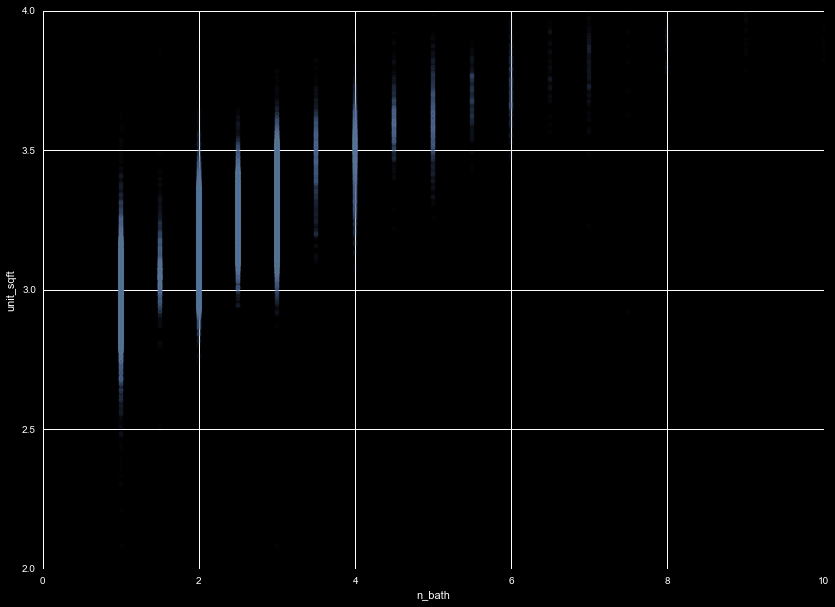

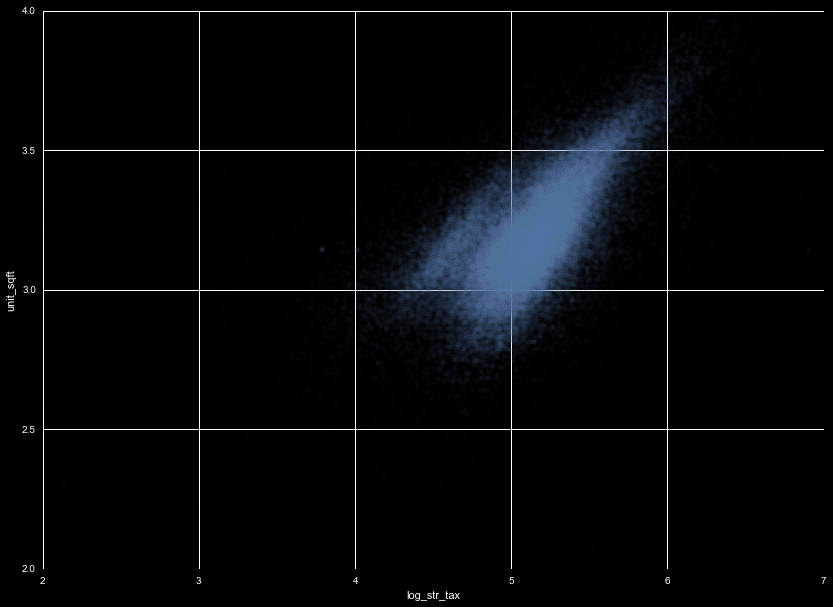

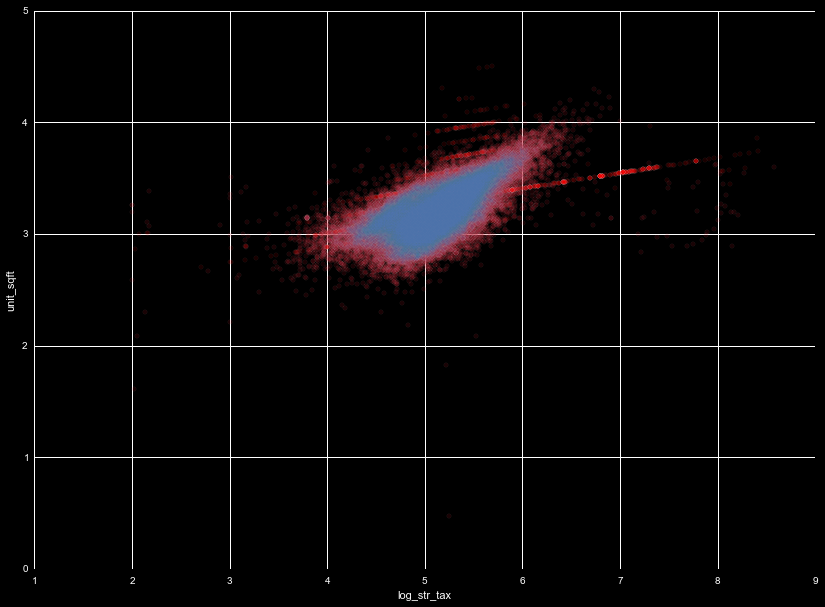

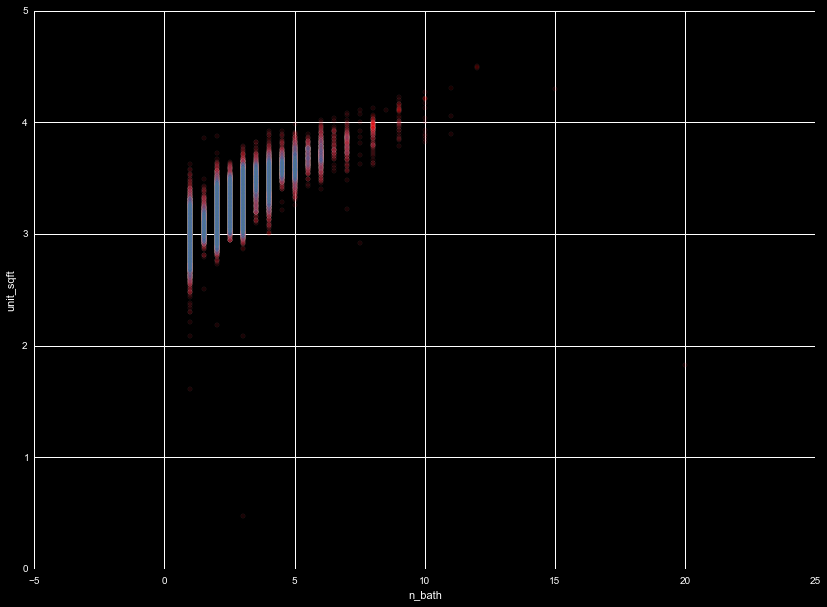

In [64]:
def reg_unit_sqft( inp_df ):

    
    # Only things we need for regression
    foo = inp_df[['unit_sqft','n_bath','log_str_tax']].copy()
    print foo.isnull().sum()

    
    foo['unit_sqft'] = np.log10( foo['unit_sqft'] +1 )
    
    # Bar is just not null values, for regression
    bar = foo.dropna()
    
    # Perform regressions
    unit_reg = linear_model.LinearRegression()
    unit_reg.fit( bar[['n_bath','log_str_tax']], bar['unit_sqft'].to_frame() )
    
#
    xx = np.array( [0, 9] )
#    
    bar.plot.scatter( x='n_bath', y='unit_sqft', alpha=0.03 )
    plt.xlim(0,10)
    plt.ylim(2,4)
    plt.show()

    bar.plot.scatter( x='log_str_tax', y='unit_sqft', alpha=0.03 )
    plt.xlim(2,7)
    plt.ylim(2,4)
    plt.show()
    
    
    # Locate bad indexes, and fill those spots with predicted values
    null_index = foo.isnull().any(axis=1)


    # Do regression
    foo.ix[ null_index, ['unit_sqft'] ] = unit_reg.predict( foo.ix[ null_index, ['n_bath','log_str_tax'] ].values )#.reshape(-1,1) )
#                                                           
    ax1 = plt.gca()
    foo.plot.scatter( x='log_str_tax', y='unit_sqft', alpha=0.1,  color='r', ax=ax1 )
    bar.plot.scatter( x='log_str_tax', y='unit_sqft', alpha=0.03, ax=ax1 )
    plt.show()
#    foo.loc[ null_index ].plot.scatter( x='log_str_tax', y='unit_sqft',  color='r', ax=ax1 )
    ax2 = plt.gca()
    foo.plot.scatter( x='n_bath', y='unit_sqft', alpha=0.1,  color='r', ax=ax2 )
    bar.plot.scatter( x='n_bath', y='unit_sqft', alpha=0.03, ax=ax2 )
    plt.show()

    return 10**foo['unit_sqft']
    
my_df['unit_sqft'] = reg_unit_sqft( my_df )

In [17]:
room_list = ['n_bath','unit_sqft','n_rooms']

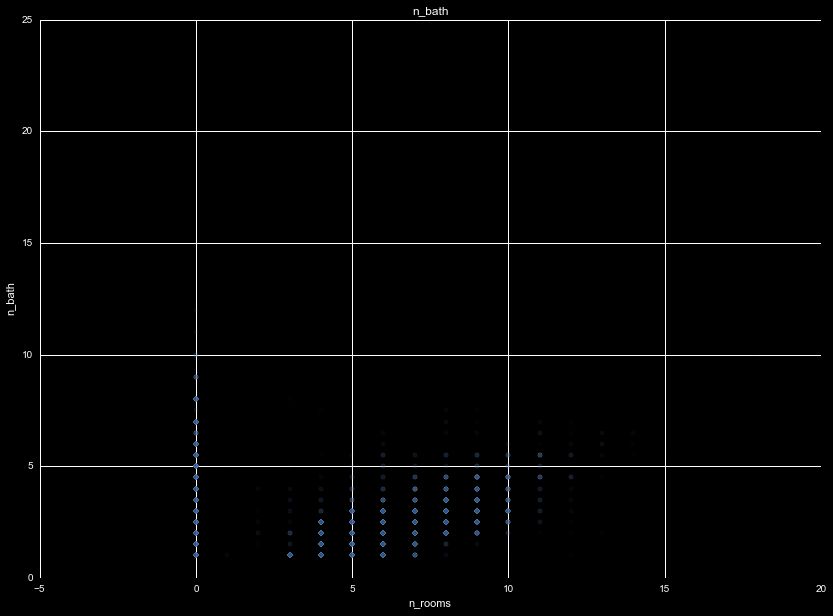

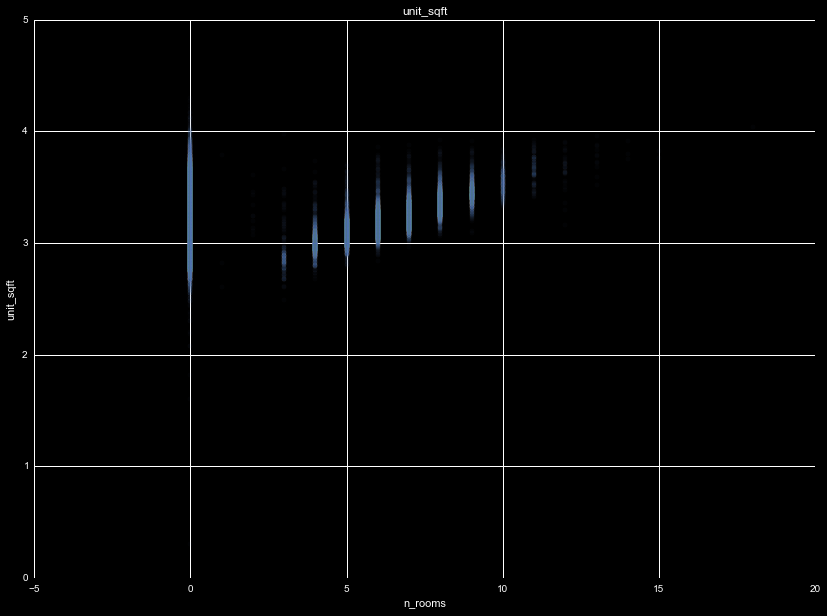

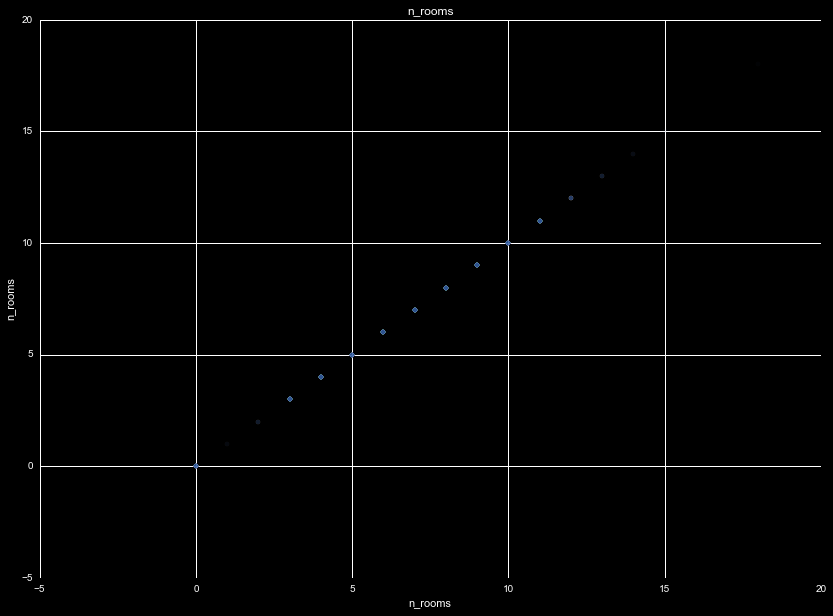

In [19]:
foo = my_df[ room_list ].copy()

foo['unit_sqft'  ] = np.log10( foo['unit_sqft'  ] )


for item in foo.columns.values:
    
    foo.plot.scatter( x='n_rooms', y=item, alpha=0.03 )
    plt.title( item )
    plt.show()

[[ 7.13989243]]
[-16.51055026]


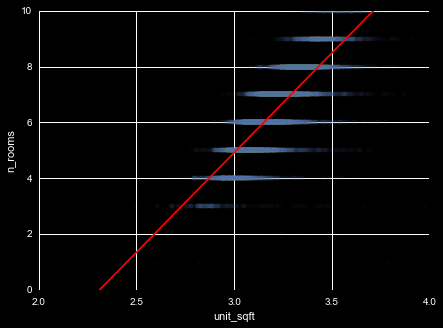

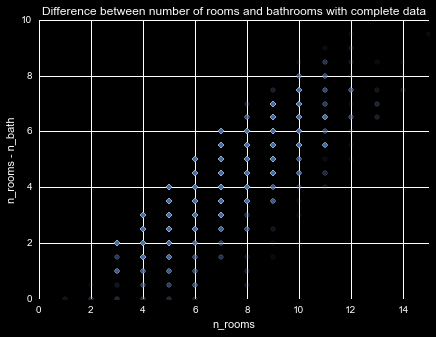

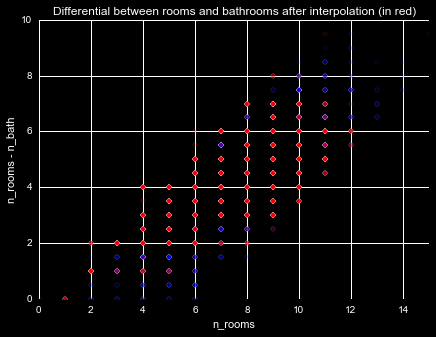

In [93]:
def reg_rooms( inp_df ):

    
    # Only things we need for regression
    foo = inp_df[['n_rooms','n_bath','unit_sqft','parcelid']].copy()
    
    foo['unit_sqft'] = np.log10( foo['unit_sqft'] )
    
    
    # Bar is just not null values, for regression
    bar = foo.loc[ foo['n_rooms']>0 ].dropna()
    
    
    # We will attempt to predict the difference between n_rooms, n_bath
    bar['diff'] = bar['n_rooms']-bar['n_bath']

    
    # Perform regressions
    room_reg = linear_model.LinearRegression()
    room_reg.fit( bar['unit_sqft'].to_frame(), bar['n_rooms'].to_frame() )

#
    print room_reg.coef_
    print room_reg.intercept_
#
    xx = np.array( [0, 9] )
#    
    bar.plot.scatter( x='unit_sqft', y='n_rooms', alpha=0.03, figsize=(7,5) )
    plt.plot( xx, room_reg.coef_[0]*xx+room_reg.intercept_ , color='r' )
    plt.xlim(2,4)
    plt.ylim(0,10)
    plt.show()   
#
    bar.plot.scatter( x='n_rooms', y='diff', alpha=0.1, figsize=(7,5) )
    plt.xlim( [0,15] )
    plt.ylim( [0,10] )
    plt.ylabel( 'n_rooms - n_bath' )
    plt.title( 'Difference between number of rooms and bathrooms with complete data' )
    plt.show()
    
    
    # Locate bad indexes, and fill those spots with predicted values
    null_index = foo.isnull().any(axis=1) | ( foo['n_rooms'] < 1 )
    
    
    # Do regression
    foo.ix[ null_index, ['n_rooms'] ] = room_reg.predict( foo.ix[ null_index, 'unit_sqft' ].values.reshape(-1,1) ).round()

    foo['diff'] = foo['n_rooms']-foo['n_bath']
        
    # if n_rooms-6.5 <= diff, n_rooms-6.5 <= n_rooms-n_bath
    foo.ix[ foo['n_rooms']-6.5 > foo['diff'], 'n_rooms' ] = ( foo.loc[ foo['n_rooms']-6.5 > foo['diff'] ]['n_rooms']-6.5 ).round()
#
    ax2 = plt.gca()
    foo.loc[ np.invert( null_index ) ].plot.scatter( x='n_rooms', y='diff', alpha=0.1, color='b', ax=ax2, figsize=(7,5) )
    foo.loc[            null_index   ].plot.scatter( x='n_rooms', y='diff', alpha=0.1, color='r', ax=ax2 )
    ax2.set_xlim( [0,15] )
    ax2.set_ylim( [0,10] )
    ax2.set_title( 'Differential between rooms and bathrooms after interpolation (in red)' )
    ax2.set_ylabel( 'n_rooms - n_bath' )
    plt.show()
    
    return foo['n_rooms']
    
blah = reg_rooms( my_df )